In [2]:
import numpy as np
import random
import copy
import math

In [3]:

class Connect4:
    def __init__(self):
        self.state = np.zeros((6, 7))
        self._drop_piece(self.state, 3, -1)

    def step(self, action, state=None):
        if state is None:
            state = self.state

        valid_move = self._drop_piece(state, action, 1)

        if not valid_move:
            raise Exception("Invalid move")

        reward = self._check_winner(state)
        if reward != 0 or self._is_board_full(state):
            return reward, True

        self._random_opponent_move(state)
        reward = self._check_winner(state)

        game_over = False
        if reward != 0 or self._is_board_full(state):
            game_over = True
        return reward, game_over

    @classmethod
    def check_terminal(cls, state):
        reward = cls._check_winner(state)
        if reward != 0 or cls._is_board_full(state):
            return True
        return False

    @classmethod
    def get_legal_moves(cls, state):
        # Check if top most cell in that column is empty
        return [col for col in range(7) if state[0][col] == 0]

    def random_rollout(self, rollout_state=None):
        if rollout_state is None:
            rollout_state = self.state.copy()
        if self._is_board_full(rollout_state):
            return 0
        # Random rollout policy
        while True:
            next_move = random.sample(self.get_legal_moves(rollout_state), 1)[0]
            reward, done = self.step(next_move, rollout_state)
            if done:
                return reward

    def reset(self):
        self.state = np.zeros((6, 7))
        self._random_opponent_move(self.state)

    @classmethod
    def _random_opponent_move(cls, state):
        # Random agent's turn
        valid_move = False
        while not valid_move:
            column = random.randint(0, 6)
            valid_move = cls._drop_piece(state, column, -1)

    @classmethod
    def _drop_piece(cls, state, column, current_player):
        # Check for valid column
        if not 0 <= column < 7 or state[0][column] != 0:
            return False  # Invalid move

        # Find the lowest empty space in the column
        for row in range(5, -1, -1):
            if state[row][column] == 0:
                state[row][column] = current_player
                return True
        return False

    @classmethod
    def _is_board_full(cls, state):
        # Check if the board is full
        return all(state[0][col] != 0 for col in range(7))

    @classmethod
    def _check_winner(cls, state):
        # Check horizontal, vertical and diagonal lines for a win
        for row in range(6):
            for col in range(7):
                if state[row][col] != 0:
                    if (
                        cls._check_line(state, row, col, 1, 0)
                        or cls._check_line(state, row, col, 0, 1)
                        or cls._check_line(state, row, col, 1, 1)
                        or cls._check_line(state, row, col, 1, -1)
                    ):
                        return state[row][col]
        return 0

    @classmethod
    def _check_line(cls, state, start_row, start_col, d_row, d_col):
        # Check a line of 4 pieces starting from (start_row, start_col) in direction (d_row, d_col)
        for i in range(1, 4):
            r = start_row + d_row * i
            c = start_col + d_col * i
            if (
                not (0 <= r < 6 and 0 <= c < 7)
                or state[r][c] != state[start_row][start_col]
            ):
                return False
        return True

In [4]:
class MCTS:
    def __init__(self, game):
        self.game = game

    def get_best_action(self, maxiter=64):
        state = self.game.state.copy()
        self.root = StateNode(None, state)

        for _ in range(maxiter):
            curnode = self._run_tree_search(self.root)
            reward = self._perform_rollout(curnode)
            self._backpropagate(curnode, reward)

        return self._get_maxq_action(self.root), self.root.actions.values()

    def _get_maxq_action(self, node):
        qval = -math.inf
        best_action = None
        
        for action in node.actions.values():
            if action.qval > qval:
                qval = action.qval
                best_action = action
        return best_action

    def _run_tree_search(self, node):
        cur_node = node
        done = self.game.check_terminal(self._state_to_np(cur_node.state))
        
        while not done:
            if len(cur_node.actions) == 0:
                cur_node_state_np = self._state_to_np(cur_node.state)
                cur_node.expand_node(self.game.get_legal_moves(cur_node_state_np))
                
            action_node = self._select_action(cur_node)
            new_state, done = self._get_next_state(cur_node.state, action_node.action)
            
            if new_state not in action_node.children_states:
                new_state_node = StateNode(action_node, new_state)
                action_node.children_states[new_state] = new_state_node
                return new_state_node
            
            cur_node = action_node.children_states[new_state]
        return cur_node

    def _perform_rollout(self, node):
        state_np = self._state_to_np(node.state)
        return self.game.random_rollout(state_np)

    def _backpropagate(self, state_node, reward):
        state_node.count += 1
        state_node.cum_reward += reward
        node = state_node
        action = node.parent
        
        while action is not None:
            node = action.parent
            action.count += 1
            action.cum_reward += reward
            node.count += 1
            node.cum_reward += reward
            action = node.parent

    def _select_action(self, node):
        best_ucb = -math.inf
        best_action = None
        
        for action in node.actions.values():
            if action.count == 0:
                curucb = math.inf
            else:
                curucb = action.qval + math.sqrt(
                    2 * math.log(node.count) / action.count
                )
            if curucb > best_ucb:
                best_ucb = curucb
                best_action = action
                
        return best_action

    def _get_next_state(self, state, action):
        state_np = self._state_to_np(state)
        _, done = self.game.step(action, state_np)
        new_state = state_np.tobytes()
        return new_state, done

    def _state_to_np(self, state):
        state_np = np.frombuffer(state, dtype=int).copy()
        state_np = state_np.reshape(self.game.state.shape)
        return state_np

In [5]:
class StateNode:
    node_count = 0

    def __init__(self, parent, state):
        self.parent = parent
        self.state = state
        self.actions = {}
        self.count = 0
        self.cum_reward = 0
        self.id = StateNode.node_count
        StateNode.node_count += 1

    def expand_node(self, available_actions):
        for action in available_actions:
            self.actions[action] = ActionNode(self, action)

    @property
    def vval(self):
        if self.count == 0:
            return 0
        return self.cum_reward / self.count

In [6]:
class ActionNode:
    def __init__(self, parent, action):
        self.parent = parent
        self.action = action
        self.children_states = {}
        self.count = 0
        self.cum_reward = 0

    @property
    def qval(self):
        if self.count == 0:
            return 0
        return self.cum_reward / self.count

In [15]:
game = Connect4()
start_state = np.array(
    [
        [0, 1, -1, -1, 1, -1, 0],
        [0, 1, 1, -1, -1, 1, 0],
        [0, -1, -1, -1, 1, -1, 0],
        [0, 1, 1, 1, -1, 1, 0],
        [0, 1, -1, -1, 1, -1, 0],
        [-1, 1, 1, 1, -1, -1, 1],
    ]
)
game.state = start_state
mcts = MCTS(game)
best_action = mcts.get_best_action(maxiter=4096)
print(
    f"best action for start state: {best_action[0].action}, expected val: {mcts.root.vval:.4f}"
)
# print(game.state)
n = 100
wins = 0
losses = 0
res = 0
draws = 0

reward = None
for _ in range(n):
    game.state = start_state.copy()
    # game.reset()
    done = False
    while not done:
        best_action = mcts.get_best_action(maxiter=1024)
        reward, done = game.step(best_action[0].action)
        if done:
            if reward > 0:
                wins += 1
            elif reward < 0:
                losses += 1
            else:
                draws += 1
            res += reward

print(f"actual value: {res / n}")
print(f"wins {wins}, losses: {losses}, draws: {draws}")

best action for start state: 0, expected val: 0.6548
actual value: 0.73
wins 73, losses: 0, draws: 27


In [21]:
def single_game():
    start_state = np.array(
        [
            [0, 1, -1, -1, 1, -1, 0],
            [0, 1, 1, -1, -1, 1, 0],
            [0, -1, -1, -1, 1, -1, 0],
            [0, 1, 1, 1, -1, 1, 0],
            [0, 1, -1, -1, 1, -1, 0],
            [-1, 1, 1, 1, -1, -1, 1],
        ]
    )

    display_actions = [
        {'index': 0, 'val': 'X'}, 
        {'index': 1, 'val': 'X'}, 
        {'index': 2, 'val': 'X'}, 
        {'index': 3, 'val': 'X'}, 
        {'index': 4, 'val': 'X'}, 
        {'index': 5, 'val': 'X'}, 
        {'index': 6, 'val': 'X'}
    ]

    game = Connect4()
    game.state = start_state
    mcts = MCTS(game)
    human_intervention = False

    done = False
    while not done:
        best_action = mcts.get_best_action(maxiter=2048)
        for action in best_action[1]:
            display_actions[action.action]['val'] = round(action.qval, 2)
        display(game.state, display_actions)
        act = best_action[0].action
        if human_intervention:
            try:
                act = int(input("Choose a column (0-6): "))
            except ValueError:
                print("Invalid input. Please enter a number between 0 and 6.")
            
        reward, done = game.step(act)
        if done:
            if reward > 0:
                print('Win')
            elif reward < 0:
                print('Lose')
            else:
                print('Draw')
            display(game.state, display_actions)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def display(board, values):
    fig, ax = plt.subplots(figsize=[7, 6])
    cmap = mcolors.ListedColormap(['green', 'white', 'blue'])
    norm = mcolors.BoundaryNorm([-1, -.5, .5, 1], cmap.N)
    ax.matshow(board, cmap=cmap, norm=norm)
    
    for x in range(8):
        ax.plot([x - .5, x - .5], [-.5, 5.5], 'k')
    for y in range(7):
        ax.plot([-.5, 6.5], [y - .5, y - .5], 'k')
        
    for v in values:
        ax.text(v['index'], -1, str(v['val']), ha='center', va='center', fontsize=20, color='black')
        
    ax.set_axis_off()
    plt.show()
    plt.close()

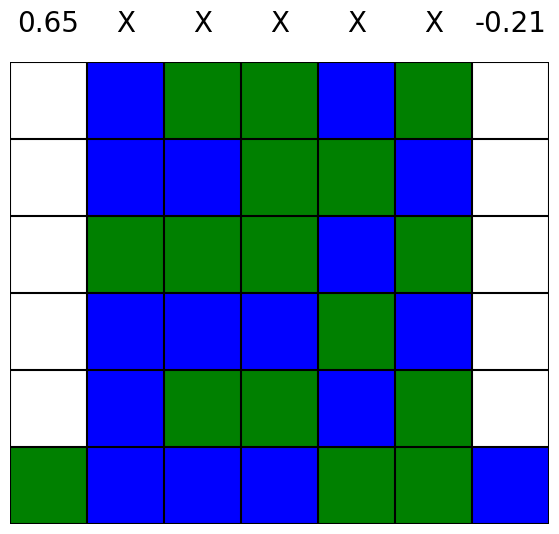

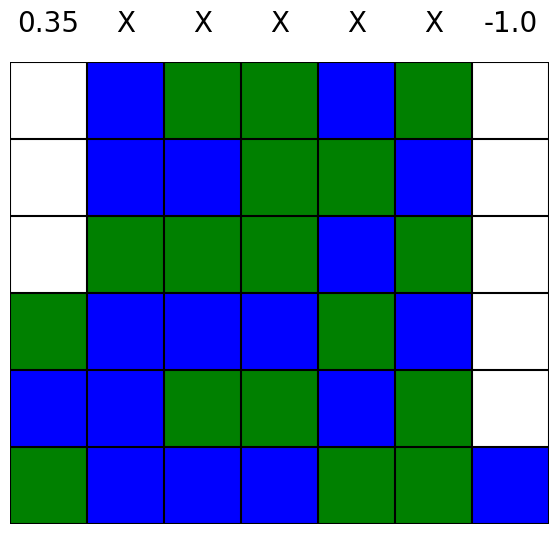

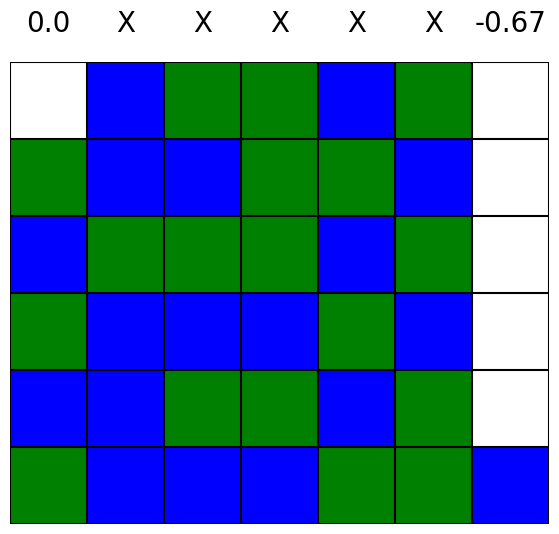

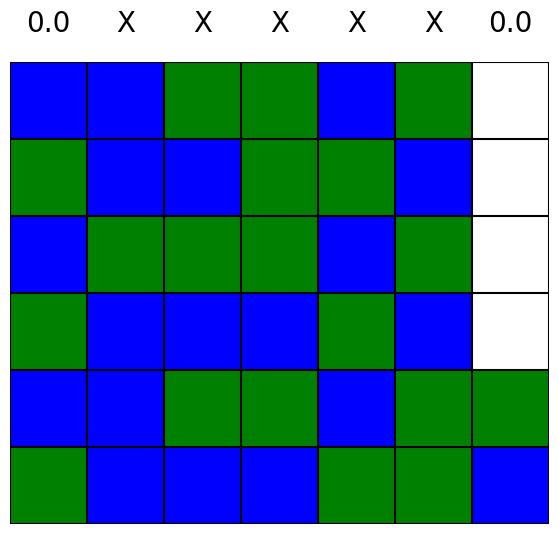

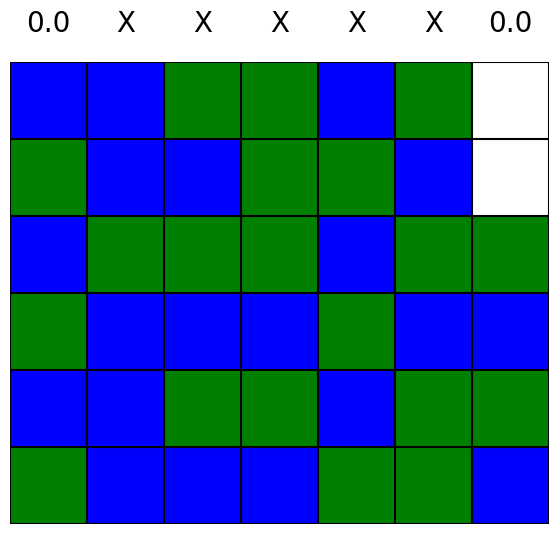

Draw


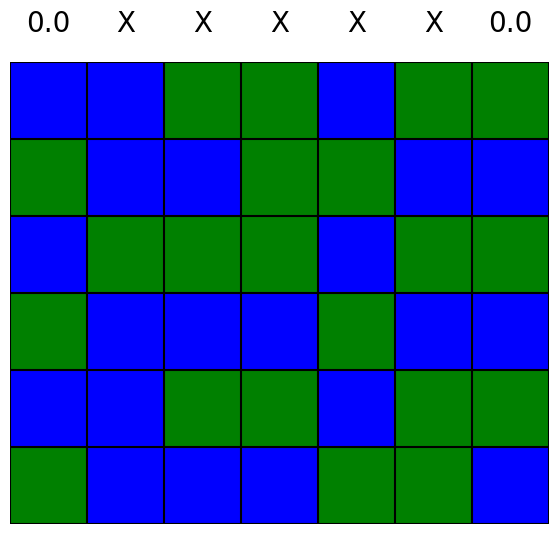

In [16]:
single_game()

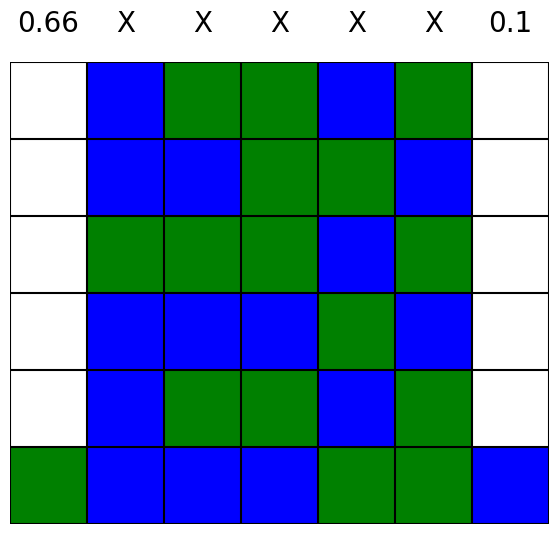

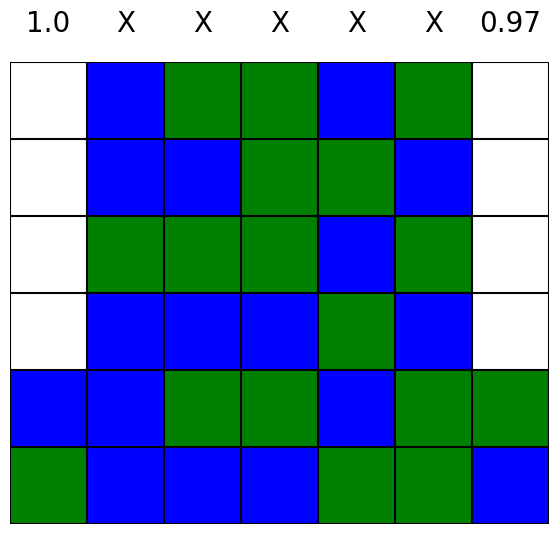

Win


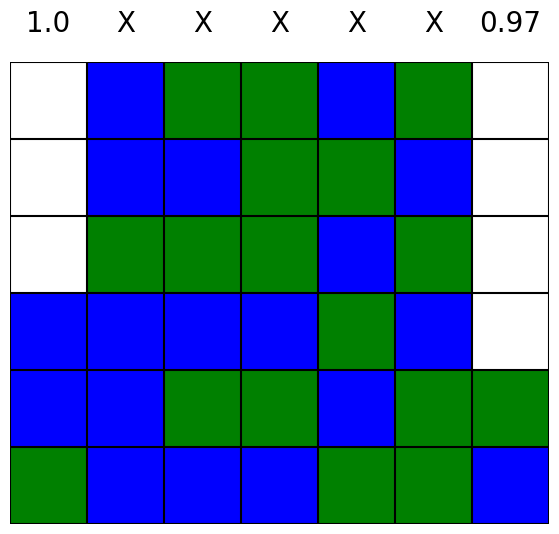

In [17]:
single_game()

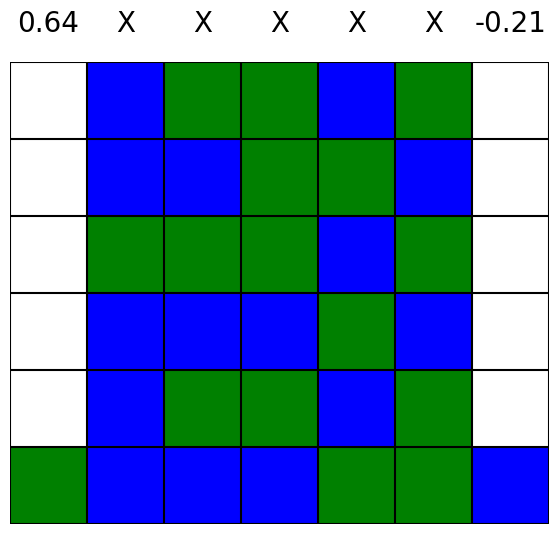

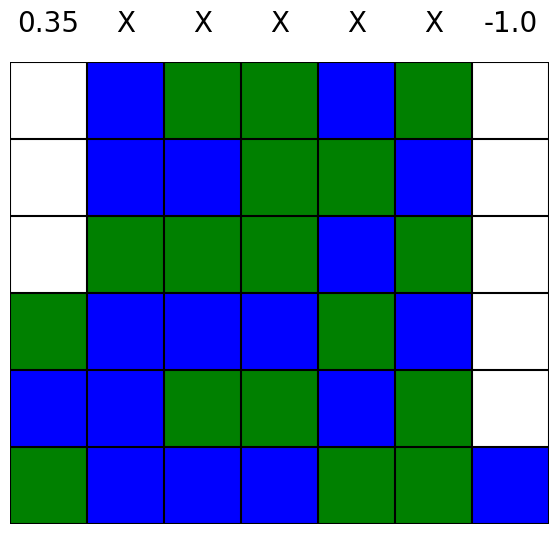

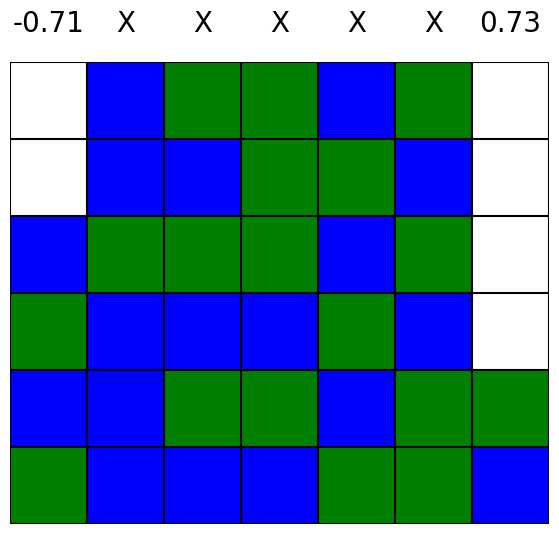

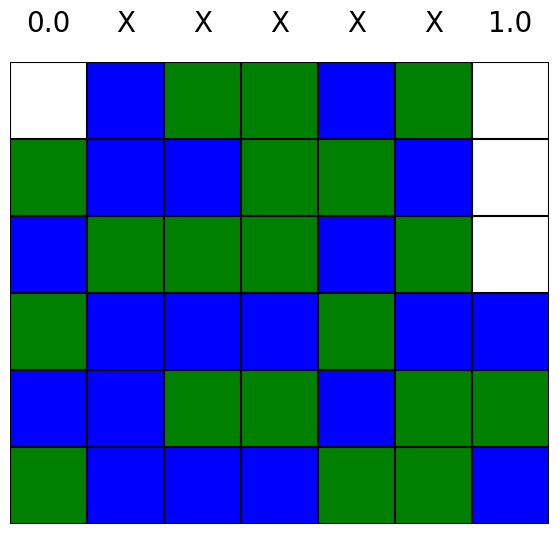

Win


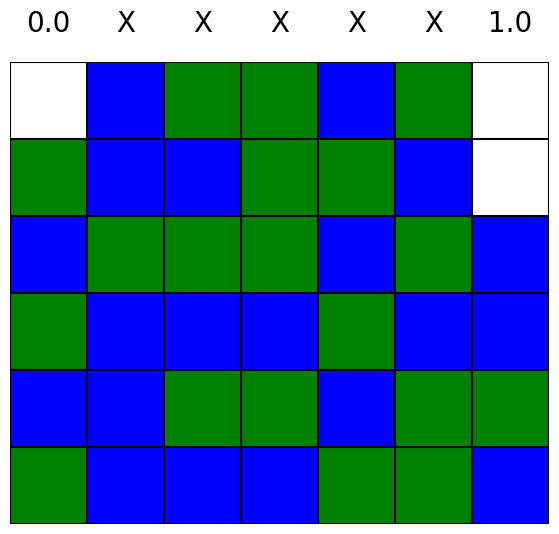

In [20]:
single_game()

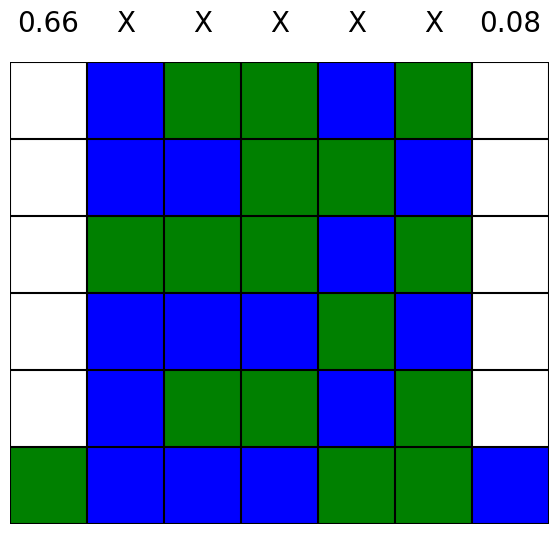

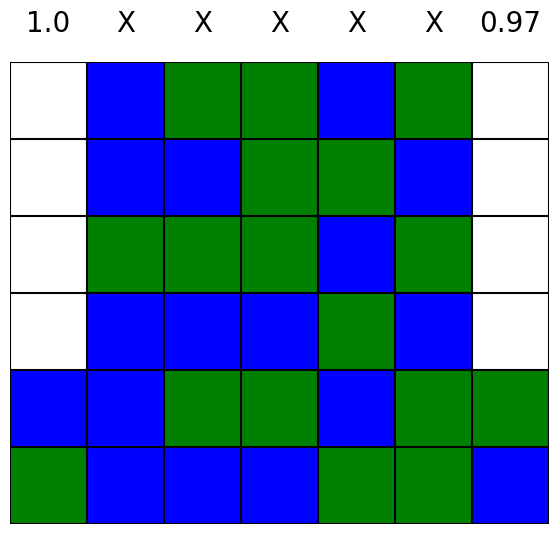

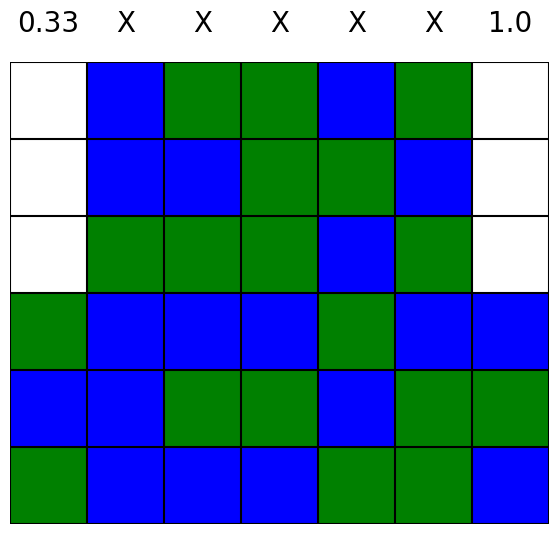

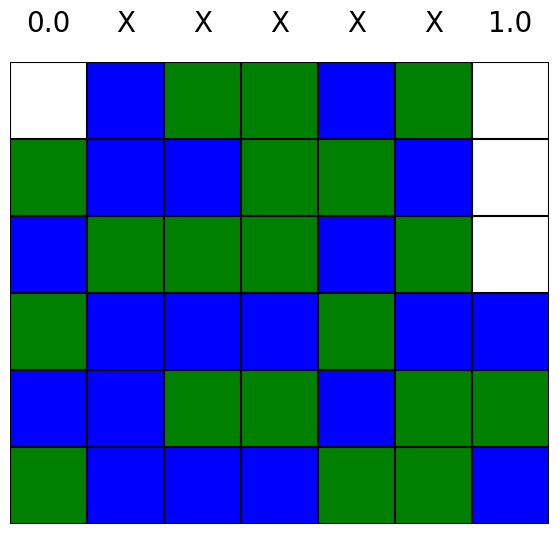

Win


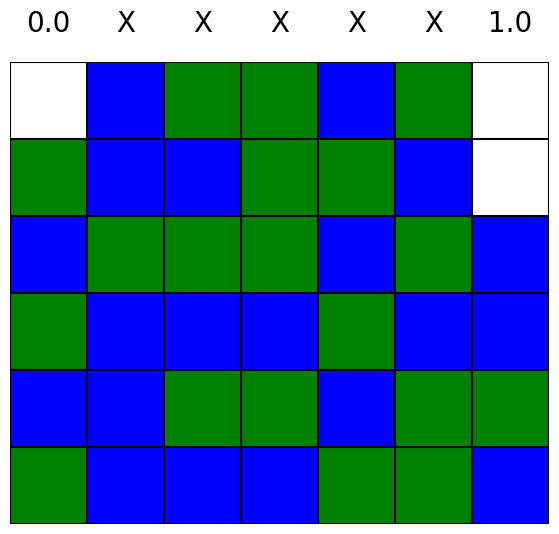

In [24]:
single_game()